<h3> Object Detection </h3>

<b>1. Using an Image Classifier(pretrained) to detect objects using keras and openCV </b>

Here we take a Convolutional Neural Network trained for image classification (pre-trained RESNET-50) and utilize `image pyramids`, `sliding windows`, and `non-maxima suppression` to build a basic object detector.Basically we combine traditional computer vision object detection algorithms with deep learning.


<b> In Image Classification :</b> Input : Image --> Output : Class Label  <br>We present the input image to our neural network, and we obtain a single class label and a probability associated with the class label prediction.This class label characterizes the contents ( the most dominant and  visible contents) of the image.<br>

<b> Object Detection :</b> Along with outputting the class labels i.e the objects present in the image, it also outputs where in the image the objects are with multiple bounding box coordinates.<br>

More specifically, it outputs 3 values,including : <br>
1. A list of bounding boxes, or the (x, y)-coordinates for each object in an image
2. The class label associated with each of the bounding boxes
3. The probability/confidence score associated with each bounding box and class label



<b> 1.1 Importing necessary modules

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import imutils

import random
import time
import cv2

import matplotlib.pyplot as plt

<b> 1.2 How deep learning image classifier can be converted into an object detector? </b>

We utilise the elements of traditional computer vision algorithms to convert our CNN image classifier into an object detector.<br>

<b>1.2.1</b> The first element we use is <b>`Image Pyramids`</b>: <br>

* An “image pyramid” is a multi-scale representation of an image:


<img src="Image_pyramid.png" style ="height: 40%;width: 40%;"/>

At the bottom of the pyramid, we have the original sized image .
At each subsequent layer, the image is resized and optionally smoothed.
The image is progressively subsampled until some stopping criterion is met( when a minimum size has been reached), and no further subsampling is required.


<b>1.2.2</b>The second element we use is <b>`Sliding Windows`</b>: <br>

* A sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image:



<img src="sliding_window.gif" style ="height: 40%;width: 40%;">

At each stop of the window we would:
1. Extract the Image within the sliding window
2. Input Image to an Image Classifier
3. obtain predictions(class label and probability scores)

<div style ="color:green">Image pyramids and sliding windows helps us localize objects at different locations and multiple scales of the input image

<b>1.2.3</b> The Third element we use is <b>`Non-Maxima Suppression`</b>: <br>

The object detectors generally outputs multiple, overlapping bounding boxes surrounding an object in an image.<br>
This happens because as the sliding window approaches an image, the classifier outputs larger and larger probabilities of  the object class(i.e higher probability of object being detected) .<br>

Since there’s only one object of a particular class,multiple bounding boxes can create a problem.<br>
The solution is to apply non-maxima suppression (NMS), which removes weak, overlapping bounding boxes by giving us the ones with higher confidence.

<img src="nms.jpg" style ="height: 50%;width: 50%;">

Below are the utility functions for implementing Image Pyramids and Sliding Windows and some other functions

In [2]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image
    # keep looping over the image pyramid
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
              break
        yield image
        
def sliding_window(image, step, ws):
      for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                 yield (x, y, image[y:y + ws[1], x:x + ws[0]])
                    
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

<b> 1.3 The steps we follow in the object detection algorithm:</b>

1. We input image.
2. We construct image pyramid fot the input image.
3. For each scale of the image pyramid, we run a sliding window:
     3.1. For each stop of the sliding window,we extract the image inside the sliding window(ROI)
     3.2. We take the sampled image and pass it through our CNN originally trained for image classification
     3.3. Examine the probability of the top class label of the CNN, and if meets a minimum confidence,we record 
            3.3.1. class label and
            3.3.2  location of the sliding window
4. We apply non-maxima suppression to the bounding boxes for different classes.
5. We return the results of the detected objects(bounding box, class label and probability)

<b>1.3.1</b> First we define some constants needed by our object detection algorithm.

In [25]:
width = 600
scale = 1.5
step = 8
roi_size = (224, 147)
INPUT_SIZE = (224, 224)
threshold_prob = 0.90

<b>1.3.2 </b> We load our ResNet classification CNN and input images from local directory

In [6]:
model = ResNet50(weights="imagenet", include_top=True)

# input_folder = './raccoon_dataset-master/images/'
# image_list = load_images(input_folder)

img = cv2.imread("./car1.jpg")
(H, W) = img.shape[:2] #We are taking the second image from out dataset of images

<b>1.3.3 </b> We initialize our image pyramid generator object and then create the scaled images from the pyramid and then preprocess the scaled images.<br> We also put the regions of interest (ROIs) generated from pyramid + sliding window output into roi_window list and store the (x, y)-coordinates of where the ROI was in the original image in the loc_in_image list

In [7]:
pyramid = image_pyramid(img, scale=scale, minSize=roi_size)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
roi_window = []
loc_in_image = []

for image in pyramid:
    scale = W / float(image.shape[1])
    for (x, y, roi) in sliding_window(image, step, roi_size):
        x = int(x * scale)
        y = int(y * scale)
        w = int(roi_size[0] * scale)
        h = int(roi_size[1] * scale)
        
        roi = cv2.resize(roi, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        
        roi_window.append(roi)
        loc_in_image.append((x, y, x + w, y + h))
        
roi_window = np.array(roi_window, dtype="float32")

<b>1.3.4 </b>  Inputting the ROIs into our pre-trained ResNet image classifier.<br>

After feeding the ROIs in the model , we decodes the predictions, grabbing only the top prediction for each ROI.

In [8]:
start = time.time()
predictions = model.predict(roi_window)
end = time.time()
print("Time taken :", end - start)

predictions = imagenet_utils.decode_predictions(predictions, top=1)

Time taken : 260.83409333229065


<b>1.3.5 </b> We loop over the predictions , and take ImageNet ID, class label, and probability and then check to see if the minimum confidence has been met <br>(i.e if the probability of the predicted ROIs is above the threshold probabilty defined in the constants earlier).<br>

Then we update the labels dictionary(labels) with the bounding box and prob score tuple (box, probs) associated with each class label.

In [9]:
labels = {}

for (i, p) in enumerate(predictions):
    (imagenetID, label, probs) = p[0]
    # filtering out weaker detections by checking the predicted probability
    # is greater than the threshols probability
    if probs >= threshold_prob:
        box = loc_in_image[i]
        labels_list = labels.get(label, [])
        labels_list.append((box, probs))
        labels[label] = labels_list

In [10]:
print(labels.keys())

dict_keys(['mortar', 'minivan', 'jeep', 'beach_wagon', 'convertible'])


<b> 1.3.6 Non-Maxima Supression </b> <br>

Since there are multiple overlapping bounding boxes detected for each class label,we use non-maxima suppression (NMS) which gives us the bounding boxes with higher confidence9among the overlapping ones).

Before that we visualise the bounding box predictions in the original image.

In [11]:
for label in labels.keys():
    clone = img.copy()
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    cv2.imshow("Before", clone)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    clone = img.copy()

We apply NMS and then visualise the final bounding box predictions in the original image.

In [13]:
for label in labels.keys():
    boxes = np.array([p[0] for p in labels[label]])
    # print(boxes)
    prob = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, prob)
    print(boxes)
    for (startX, startY, endX, endY) in boxes:
            cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    cv2.imshow("After", clone)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    clone = img.copy()

[[ 48 128 272 275]]
[[232 208 456 355]
 [360 264 584 411]
 [276  72 612 292]
 [ 24  84 360 304]]
[[  0 152 224 299]]
[[ 72 108 408 328]]
[[136 240 360 387]]


<h2> 2. Selective Search </h2>

In [27]:
image = img
method = 'quality' #or 'quality'

In [28]:
def selectiveSearch(image,method):
    select_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    select_search.setBaseImage(image)
    
    if method == "fast":
        select_search.switchToSelectiveSearchFast()
    else:
        select_search.switchToSelectiveSearchQuality()
        
    regions = select_search.process()
    return regions

regions = selectiveSearch(image,method)

In [29]:
for i in range(0, len(regions), 100):
    output = image.copy()
    # loop over the current subset of region proposals
    for (x, y, w, h) in regions[i:i + 100]:
        # draw the region proposal bounding box on the image
        color = [random.randint(0, 255) for _ in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
    # show the output image
    cv2.imshow("Output", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
output = image.copy()

<h2> 3. Object Detector using Selective Search </h2>

In [44]:
# filter_class = ['apple'] #Imagenet classes to consider
proposals = [] #holds pre-processed ROIs from our input image, which will be fed into our ResNet classifier.
bbox = [] # list of bounding box coordinates corresponding to our proposals
#NOTE: Only sufficiently large proposal regions are included.

In [45]:
# if the width or height of the region is less than 10% of the
# image width or height, ignore it (i.e., filter out small
# objects that are likely false-positives)
for (x, y, w, h) in regions:
    if w / float(W) < 0.4 or h / float(H) < 0.2 or h / float(H) >0.6 or w / float(W) > 0.85 :
        continue
        
    region_interest = image[y:y + h, x:x + w]
    region_interest = cv2.cvtColor(region_interest, cv2.COLOR_BGR2RGB) #BGR to RGB
    region_interest = cv2.resize(region_interest, (224, 224)) #resize it to 224x224;input dim of RESNET50
    
    region_interest = img_to_array(region_interest)
    region_interest = preprocess_input(region_interest)
    proposals.append(region_interest)
    bbox.append((x, y, w, h)) 

In [46]:
proposals = np.array(proposals)
print(proposals.shape)

predictions = model.predict(proposals)
predictions = imagenet_utils.decode_predictions(predictions, top=1)

(407, 224, 224, 3)


In [47]:
labels = {}
for (i, p) in enumerate(predictions):
    (imagenetID, label, probability) = p[0]
    #if label does not exist in the filter class list, ignore it
#     if filter_class is not None and label not in filter_class:
#         continue
    # filtering out detections whose predicted probability
    # is lesser than the threshold probability    
    if probability >= threshold_prob:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        (x, y, w, h) = bbox[i]
        box = (x, y, x + w, y + h)
        # grab the list of predictions for the label and add the
        # bounding box + probability to the list
        label_list = labels.get(label, [])
        label_list.append((box, probability))
        labels[label] = label_list

In [34]:
# labels

In [48]:
labels.keys()

dict_keys(['minivan', 'car_wheel'])

In [49]:
    
for label in labels.keys():    
    boxes = np.array([p[0] for p in labels[label]])
    prob = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, prob)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(output, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(output, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    cv2.imshow("After", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    output = image.copy()

In [3]:
from bs4 import BeautifulSoup
from imutils import paths
import cv2
import os

<h2>Training a RCNN from scratch</h2>

We will use the following steps to train a R-CNN model:
    
1. Using Selective Search, we build an object detection dataset.

2. Then we fine-tune a object classification network that is originally trained on ImageNet dataset(MobileNet, pre-trained on ImageNet).

3. We create an object detection script that utilizes Selective Search to propose regions that could contain an object that we would like to detect.

4. Use our fine-tuned network to classify each region proposed via Selective Search

5. Apply non-maxima suppression to suppress weak, overlapping bounding boxes.

6. Return the final object detection results

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


In [8]:
#configurations

images_orig = './Data/images'
labels_orig = './Data/annotations'

base_path = './custom_dataset/'
racoon = './custom_dataset/racoon'
no_racoon = './custom_dataset/no_racoon'

max_region_proposal_train = 2000
max_region_proposal_infer = 200

max_positive_per_image = 30
max_negative_per_image = 10

#Model specific
input_dims = (224, 224)

MODEL_PATH = "model/raccoon_detector.h5"
ENCODER_PATH = "lmodel/abel_encoder.pickle"
#The minimum probability required for a positive prediction during inference (used to filter out false-positive detections)
#is set to 99%
min_probability = 0.99

To measure performance of our object detector at predicting bounding boxes, we use the Intersection over Union (IoU) metric.

`The IoU method computes the ratio of the area of overlap to the area of the union between the predicted bounding box and the ground-truth bounding box:`

<img src = 'IOU1.png'/>

IoU is used to measure object detection accuracy, i.e how much a given Selective Search proposal overlaps with a ground-truth bounding box (useful in generating racoon and no-racoon examples for our training data).

In [2]:
def cal_iou(box_proposed, box_groundtruth):
    # determine the (x, y)-coordinates of the intersection rectangle
    x1 = max(box_proposed[0], box_groundtruth[0])
    y1 = max(box_proposed[1], box_groundtruth[1])
    x2 = min(box_proposed[2], box_groundtruth[2])
    y2 = min(box_proposed[3], box_groundtruth[3])
    # compute the area of intersection rectangle
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    area_1 = (box_proposed[2] - box_proposed[0] + 1) * (box_proposed[3] - box_proposed[1] + 1)
    area_2 = (box_groundtruth[2] - box_groundtruth[0] + 1) * (box_groundtruth[3] - box_groundtruth[1] + 1)
    union = float(area_1 + area_2 - intersection)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection / union
    # return the intersection over union value
    return iou

<h3> 1 . Building object detection dataset using selective search </h3>

Steps used to build our custom datasets:

1. We take the input images data and the bounding box data from local directories

2. Loop over all images.

   * load the input image 
   * For each image we get the ground truth bounding box co-ordinates for any  racoon .
   * We run selective search on the input image to get the region proposals for the input image.
   
   * We calculate IoU to determine whether  or not the region proposals from Selective Search sufficiently overlap with the ground-truth bounding boxes 
   
   * We then save the region proposals which are  overlapping (contains raccoon) in the ./custom-dataset/racoon directory and which doenot not (no raccoon) in ./custom-dataset/no_racoon directory.

In [57]:
countPositive = 0
countNegative = 0

#taking all image paths in the input images directory
image_paths = list(paths.list_images(images_orig))

for (i, path) in enumerate(image_paths):
    file = path.split(os.path.sep)[-1]
    file = file[:file.rfind(".")]
    label_path = os.path.sep.join([labels_orig,"{}.xml".format(file)])
    
    contents = open(label_path).read()
    soup = BeautifulSoup(contents, "html.parser")
    gt_bb = []
    # extract the image dimensions
    width = int(soup.find("width").string)
    height = int(soup.find("height").string)
    
    for obj in soup.find_all("object"):
        # extract the label and bounding box coordinates
        label = obj.find("name").string
        xMin = int(obj.find("xmin").string)
        yMin = int(obj.find("ymin").string)
        xMax = int(obj.find("xmax").string)
        yMax = int(obj.find("ymax").string)
        # truncate any bounding box coordinates that may fall
        # outside the boundaries of the image
        xMin = max(0, xMin)
        yMin = max(0, yMin)
        xMax = min(width, xMax)
        yMax = min(height, yMax)
        # update our list of ground-truth bounding boxes
        gt_bb.append((xMin, yMin, xMax, yMax))
        
    image = cv2.imread(path)
    # run selective search on the image and initialize our list of
    # proposed boxes
    sel_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    sel_search.setBaseImage(image)
    sel_search.switchToSelectiveSearchFast()
    rects = sel_search.process()
    
    regionproposed = []
    # loop over the rectangles generated by selective search
    for (x, y, w, h) in rects:
        # convert our bounding boxes from (x, y, w, h) to (startX,
        # startY, startX, endY)
        regionproposed.append((x, y, x + w, y + h))
        
    positive_bb = 0
    negative_bb = 0
    
    for region in regionproposed[:max_region_proposal_train]:
        # unpack the proposed rectangle bounding box
        (StartX, StartY, EndX, EndY) = region
        # loop over the ground-truth bounding boxes
        for bb in gt_bb:
            # compute the intersection over union between the two
            # boxes and unpack the ground-truth bounding box
            iou = cal_iou(bb, region)
            (gtStartX, gtStartY, gtEndX, gtEndY) = bb
#             print(gtStartX, gtStartY, gtEndX, gtEndY)
            # initialize the ROI and output path
            roi = None
            outputPath = None

            if iou > 0.7 and positive_bb <= max_positive_per_image:
                    # extract the ROI and then derive the output path to
                    # the positive instance
                    roi = image[StartY:EndY, StartX:EndX]
                    filename = "{}.png".format(countPositive)
                    outputPath = os.path.sep.join([racoon,filename])
                    # increment the positive counters
                    positive_bb += 1
                    countPositive += 1
                    
            fullOverlap = StartX >= gtStartX
            fullOverlap = fullOverlap and StartY >= gtStartY
            fullOverlap = fullOverlap and EndX <= gtEndX
            fullOverlap = fullOverlap and EndY <= gtEndY
            
            if not fullOverlap and iou < 0.05 and negative_bb <= max_negative_per_image:
                # extract the ROI and then derive the output path to
                # the negative instance
                roi = image[StartY:EndY, StartX:EndX]
                filename = "{}.png".format(countNegative)
                outputPath = os.path.sep.join([no_racoon,filename])
                # increment the negative counters
                negative_bb += 1
                countNegative += 1
            if roi is not None and outputPath is not None:
                # resize the ROI to the input dimensions of the CNN
                # that we'll be fine-tuning, then write the ROI to
                # disk
                roi = cv2.resize(roi, input_dims,interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

In [66]:
print('No of images in racoon custom dataset: ',len([f for f in os.listdir(racoon)]))
print('No of images in no_racoon custom dataset: ',len([f for f in os.listdir(no_racoon)]))

No of images in racoon custom dataset:  1563
No of images in no_racoon custom dataset:  2200


<h3> 2. Fine-tune a object classification network that is originally trained on ImageNet dataset(MobileNet, pre-trained on ImageNet).

In [4]:
accuracy_loss_plot = 'plot.png'

learn_rate_init = 1e-4
epochs = 5
batch_size = 32

In [89]:
def loadImageslabels(img_dir):   
    image_paths = list(paths.list_images(img_dir))
    images = []
    labels = []
    # loop over the image paths
    for ip in image_paths:
        # extract the class label from the filename
        label = ip.split(os.path.sep)[-2].split('/')[-1]
        # load the input image (224x224) and preprocess it
        image = load_img(ip, target_size = input_dims)
        image = img_to_array(image)
        image = preprocess_input(image)
        # update the data and labels lists, respectively
        images.append(image)
        labels.append(label)
    return images,labels

In [94]:
images,labels = loadImageslabels(base_path)

In [95]:
images = np.array(images, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


# Train/test splits using 75% of the data for training and the remaining 25% for testing
(X_train, X_test, y_train, y_test) = train_test_split(images, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [107]:
#saving label encoder
file = open("label_encoder.pickle", "wb")
file.write(pickle.dumps(lb))
file.close()

The MobileNet base network has pre-trained weights that are frozen. We will only train the head of the network as done below. Notice that the head of our network has a Softmax Classifier with 2 outputs.these outputs corresponds to our raccoon and no_raccoon classes.

In [97]:
# Loading  MobileNet pre-trained on the ImageNet dataset, leaving off fully-connect (FC) head
# here include_top = false cuts of the head from the base model
base_model = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

#constructing  a new fully connected head of the model that is placed on top of the base model
head = base_model.output
head = AveragePooling2D(pool_size=(7, 7))(head)
head = Flatten(name="flatten")(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(2, activation="softmax")(head)

model = Model(inputs=base_model.input, outputs=head)

# Freezing the base layers of MobileNet (setting them as not trainable)
for layer in base_model.layers:
    layer.trainable = False

In [99]:
optimizer = Adam(lr = learn_rate_init)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
history = model.fit(aug.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test, y_test),validation_steps=len(X_test) // batch_size, epochs=epochs)

[INFO] training head...
  ...
    to  
  ['...']
Train for 94 steps, validate on 753 samples
Epoch 1/5
94/94 [==============================] - 608s 6s/step - loss: 0.3352 - accuracy: 0.8590 - val_loss: 0.1424 - val_accuracy: 0.9660
Epoch 2/5
94/94 [==============================] - 614s 7s/step - loss: 0.1299 - accuracy: 0.9567 - val_loss: 0.0909 - val_accuracy: 0.9810
Epoch 3/5
94/94 [==============================] - 606s 6s/step - loss: 0.0838 - accuracy: 0.9725 - val_loss: 0.0552 - val_accuracy: 0.9905
Epoch 4/5
94/94 [==============================] - 618s 7s/step - loss: 0.0711 - accuracy: 0.9788 - val_loss: 0.0629 - val_accuracy: 0.9864
Epoch 5/5
94/94 [==============================] - 603s 6s/step - loss: 0.0622 - accuracy: 0.9812 - val_loss: 0.0363 - val_accuracy: 0.9932


In [100]:
predictions = model.predict(X_test, batch_size = batch_size)
# for each image in the testset we find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=1)

print(classification_report(y_test.argmax(axis=1), predictions, target_names=lb.classes_))

              precision    recall  f1-score   support

   no_racoon       1.00      0.99      0.99       440
      racoon       0.99      0.99      0.99       313

    accuracy                           0.99       753
   macro avg       0.99      0.99      0.99       753
weighted avg       0.99      0.99      0.99       753



In [105]:
def plot_performance(history,epochs):
    plt.style.use("ggplot")
    plt.figure(figsize = (15,10))
    plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(accuracy_loss_plot)

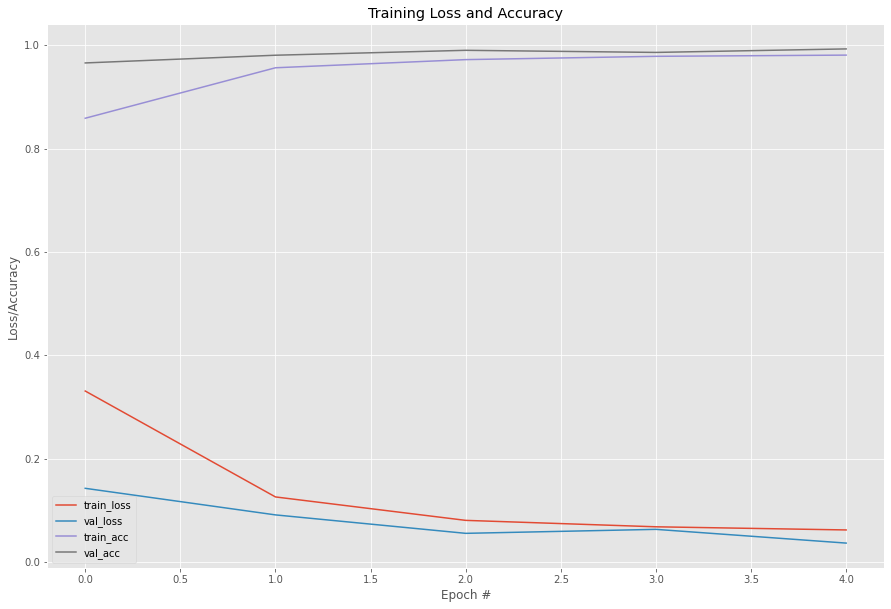

In [106]:
model.save('custom_rcnn_model.h5')

plot_performance(history,epochs)

<h3> 3. Selective Search to propose regions that could contain an object that we would like to detect.

In [28]:
model = load_model('custom_rcnn_model.h5')
lb = pickle.loads(open('label_encoder.pickle', "rb").read())

In [29]:
image = cv2.imread(os.path.join(images_orig,'raccoon-1.jpg'))
image = imutils.resize(image, width=500)


select_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
select_search.setBaseImage(image)
select_search.switchToSelectiveSearchFast()
bbox = select_search.process()

proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in bbox[ : max_region_proposal_infer]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, input_dims, interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))
    
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")

<h3> 4. Using our fine-tuned network to classify each region proposed via Selective Search

In [30]:
predictions = model.predict(proposals)

labels = lb.classes_[np.argmax(predictions, axis=1)]
labels = np.array(labels)
ids = np.where(labels == 'racoon')[0]

# use the indexes to extract all bounding boxes and associated class
# label probabilities associated with the "raccoon" class
boxes = boxes[ids]
predictions = predictions[ids][:, 1]


# further filter indexes by enforcing a minimum prediction
# probability be met
idx = np.where(predictions >= min_probability)
boxes = boxes[idx]
predictions = predictions[idx]

In [49]:
clone = image.copy()
i = 0
a = []
for (box, preds) in zip(boxes, predictions):
    (startX, startY, endX, endY) = box
    a.append((box,i))
    i += 1
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text= "Raccoon: {:.2f}%".format(preds * 100)
    cv2.putText(clone, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    
#     output = image.copy()
cv2.imshow("Before NMS", clone)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
clone = image.copy()

<img src = 'custom_ccn_b4_nms.png'/>

<h3> 5. Apply non-maxima suppression to suppress weak, overlapping bounding boxes and show the results of our object  detector

In [63]:
box = non_max_suppression(boxes, predictions)

# loop over the bounding box indexes
for (startX, startY, endX, endY) in box:
        box1 = np.array([startX, startY, endX, endY])
        text = ''
        # draw the bounding box and label on the image
        cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        for item in a:
            if(np.array_equal(item[0],box1)):
                i = item[1]
                text= "Raccoon: {:.2f}%".format(predictions[i] * 100)
        cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
cv2.imshow("After", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
clone = image.copy()


<img src = 'custom_ccn_after_nms.png'/>

<h2>Yolo Model

In [221]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model,load_model
from keras.preprocessing.image import load_img

import struct
import cv2
from matplotlib.patches import Rectangle


https://github.com/experiencor/keras-yolo3

https://pjreddie.com/media/files/yolov3.weights
    

In [226]:
def yoloV3Model():
    input_img = Input(shape=(None,None, 3))
    print(input_img.shape)
    
    x = _conv_block(input_img, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
    
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
    
    
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], 
                    skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}],
                          skip=False)
    
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_img, [yolo_82, yolo_94, yolo_106])    
    return model
    
    
    
    
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: 
            x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: 
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x    
    

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image(filename, shape):
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(filename)
    print(data.shape)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white')
    # show the plot
    plt.show()

In [98]:
model = yoloV3Model()

weigths = WeightReader('./Yolo/yolov3.weights')
weigths.load_weights(model)

model.save('model.h5')

(None, None, None, 3)
loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weig

In [251]:
model = load_model('model.h5')

In [252]:
filepath = "./zebra.jpg"

In [253]:
img = load_image(filepath,(416,416))
orig_image = load_img(filepath)
W , H = img.shape[1:3]
W_orig, H_orig = orig_image.size
print("Shape of input Image : ",img.shape)
print("Shape of original Image : ",orig_img.shape)

Shape of input Image :  (1, 416, 416, 3)
Shape of original Image :  (483, 800, 3)


In [254]:
print(W_orig,H_orig)

800 483


In [255]:
y_prediction = model.predict(img)
print([x.shape for x in y_prediction])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [256]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
class_threshold = 0.6
boxes = list()
for i in range(len(y_prediction)):
    # decode the output of the network
    boxes += decode_netout(y_prediction[i][0], anchors[i], class_threshold, H, W)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, H_orig, W_orig, H, W)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

In [257]:
#The list of class labels in the order used during training
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# get the details of the detected objects
boxes_, labels_, scores_ = get_boxes(boxes, labels, class_threshold)

In [258]:
for i in range(len(labels_)):
    print(labels_[i],scores_[i])

zebra 96.40049934387207
zebra 99.84570741653442
zebra 97.51414060592651


(483, 800, 3)


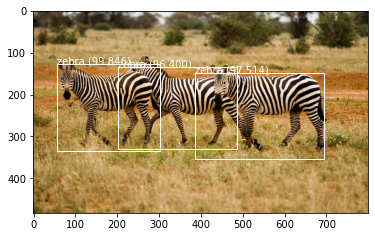

In [259]:
draw_boxes("./zebra.jpg", boxes_, labels_, scores_)